# Inflation Forecasting

In [36]:
# import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import tensorflow as tf

In [28]:
# import data
df = pd.read_csv('./inflasi-indo.csv')
df

,Unnamed: 0,date,inflation-rate
0,0,2003-01-01,2.86
1,1,2003-02-01,2.56
2,2,2003-03-01,2.28
3,3,2003-04-01,3.27
4,4,2003-05-01,3.08
...,...,...,...
246,246,2023-07-01,7.15
247,247,2023-08-01,7.62
248,248,2023-09-01,7.17
249,249,2023-10-01,7.60


In [29]:
def plot_series(x, y, format="-", start=0, end=None,
                title=None, xlabel=None, ylabel=None, legend=None ):
    """
    Visualizes time series data

    Args:
      x (array of int) - contains values for the x-axis
      y (array of int or tuple of arrays) - contains the values for the y-axis
      format (string) - line style when plotting the graph
      start (int) - first time step to plot
      end (int) - last time step to plot
      title (string) - title of the plot
      xlabel (string) - label for the x-axis
      ylabel (string) - label for the y-axis
      legend (list of strings) - legend for the plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))

    # Check if there are more than two series to plot
    if type(y) is tuple:

      # Loop over the y elements
      for y_curr in y:

        # Plot the x and current y values
        plt.plot(x[start:end], y_curr[start:end], format)

    else:
      # Plot the x and y values
      plt.plot(x[start:end], y[start:end], format)

    # Label the x-axis
    plt.xlabel(xlabel)

    # Label the y-axis
    plt.ylabel(ylabel)

    # Set the legend
    if legend:
      plt.legend(legend)

    # Set the title
    plt.title(title)

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

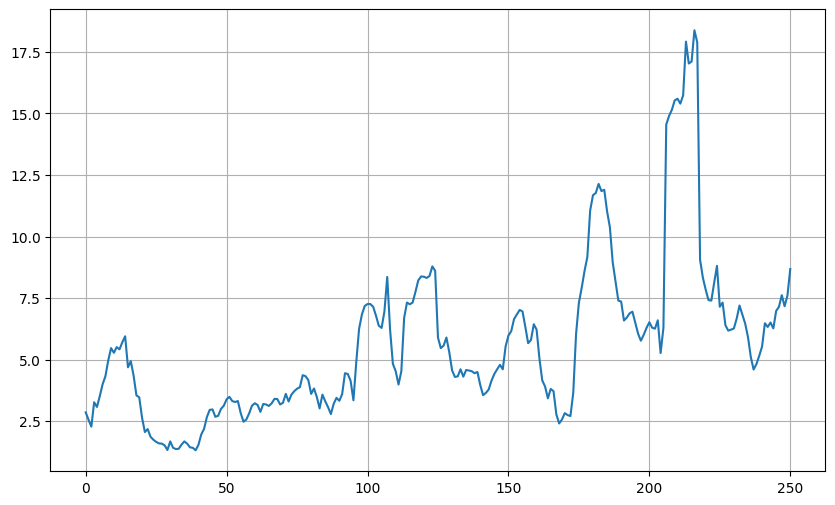

In [31]:
time_step = []
inflation = []

with open ('./inflasi-indo.csv') as f:
    reader = csv.reader(f, delimiter=',')
    next(reader)

    for row in reader:
        time_step.append(int(row[0]))
        inflation.append(float(row[2]))

time = np.array(time_step)
series = np.array(inflation)
# plt.figure(figsize=(10, 6))
plot_series(time, series)

In [75]:
# Define the split time
split_time = 225

# Get the train set
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

In [34]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  """
  Creates a windowed dataset out of a time series

  Args:
    series (array of int) - contains the time series
    window_size (int) - the size of the window
    batch_size (int) - the size of the batch
    shuffle_buffer (int) - the size of the shuffle buffer

  Returns:
    dataset - a windowed dataset
  """

  # Create a dataset from the series
  dataset = tf.data.Dataset.from_tensor_slices(series)

  # Window the dataset
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)

  # Flatten the dataset
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

  # Shuffle the dataset
  dataset = dataset.shuffle(shuffle_buffer)

  # Map the dataset so that it contains the window and the label
  dataset = dataset.map(lambda window: (window[:-1], window[-1]))

  # Batch the dataset
  dataset = dataset.batch(batch_size).prefetch(1)

  return dataset

In [76]:
# parameters for the windowed dataset
window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

# Create the windowed dataset
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [77]:
# Build the Model
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=64, kernel_size=3,
                      strides=1,
                      activation="relu",
                      padding='causal',
                      input_shape=[window_size, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

 # Print the model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 30, 64)            256       
                                                                 
 lstm_2 (LSTM)               (None, 30, 64)            33024     
                                                                 
 lstm_3 (LSTM)               (None, 64)                33024     
                                                                 
 dense_3 (Dense)             (None, 30)                1950      
                                                                 
 dense_4 (Dense)             (None, 10)                310       
                                                                 
 dense_5 (Dense)             (None, 1)                 11        
                                                                 
 lambda_1 (Lambda)           (None, 1)                

In [78]:
init_weight = model.get_weights()
# print(init_weight)

In [95]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

# Train the model
history = model.fit(train_set, epochs=70, callbacks=[lr_schedule])

Epoch 1/70


7/7 [==============================] - 4s 25ms/step - loss: 2.1370 - lr: 1.0000e-08
Epoch 2/70
7/7 [==============================] - 0s 25ms/step - loss: 2.1356 - lr: 1.1220e-08
Epoch 3/70
7/7 [==============================] - 0s 23ms/step - loss: 2.1334 - lr: 1.2589e-08
Epoch 4/70
7/7 [==============================] - 0s 23ms/step - loss: 2.1307 - lr: 1.4125e-08
Epoch 5/70
7/7 [==============================] - 0s 24ms/step - loss: 2.1284 - lr: 1.5849e-08
Epoch 6/70
7/7 [==============================] - 0s 21ms/step - loss: 2.1251 - lr: 1.7783e-08
Epoch 7/70
7/7 [==============================] - 0s 21ms/step - loss: 2.1219 - lr: 1.9953e-08
Epoch 8/70
7/7 [==============================] - 0s 21ms/step - loss: 2.1173 - lr: 2.2387e-08
Epoch 9/70
7/7 [==============================] - 0s 21ms/step - loss: 2.1133 - lr: 2.5119e-08
Epoch 10/70
7/7 [==============================] - 0s 23ms/step - loss: 2.1108 - lr: 2.8184e-08
Epoch 11/70
7/7 [==============================] - 0s 28ms/s

(1e-08, 0.001, 0.0, 100.0)

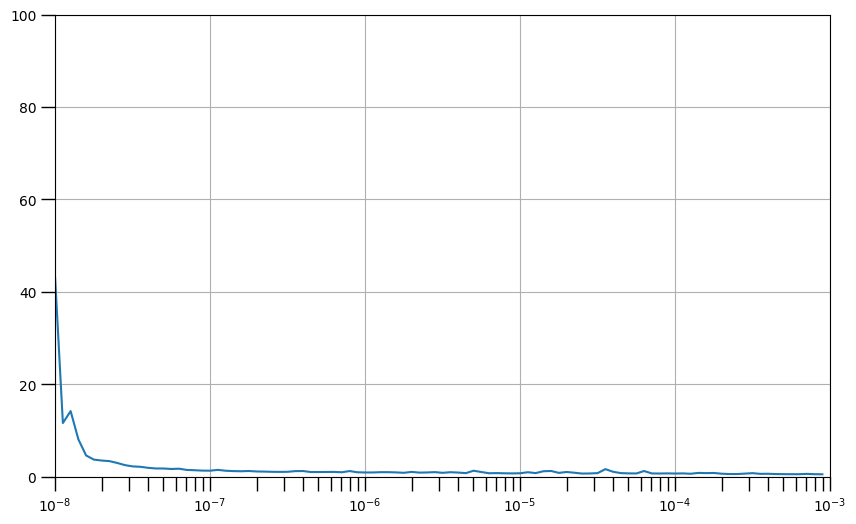

In [103]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 100])

In [98]:
tf.keras.backend.clear_session()
model.set_weights(init_weight)

In [99]:
# Set the learning rate
learning_rate = 8e-7

# Set the optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [100]:
history = model.fit(train_set, epochs=100)

Epoch 1/100
7/7 [==============================] - 4s 25ms/step - loss: 43.0132 - mae: 43.5132
Epoch 2/100
7/7 [==============================] - 0s 21ms/step - loss: 11.6078 - mae: 12.1023
Epoch 3/100
7/7 [==============================] - 0s 29ms/step - loss: 14.1860 - mae: 14.6826
Epoch 4/100
7/7 [==============================] - 0s 21ms/step - loss: 8.0727 - mae: 8.5662
Epoch 5/100
7/7 [==============================] - 0s 21ms/step - loss: 4.5828 - mae: 5.0720
Epoch 6/100
7/7 [==============================] - 0s 23ms/step - loss: 3.6909 - mae: 4.1632
Epoch 7/100
7/7 [==============================] - 0s 21ms/step - loss: 3.4870 - mae: 3.9482
Epoch 8/100
7/7 [==============================] - 0s 21ms/step - loss: 3.3634 - mae: 3.8455
Epoch 9/100
7/7 [==============================] - 0s 21ms/step - loss: 2.9702 - mae: 3.4333
Epoch 10/100
7/7 [==============================] - 0s 23ms/step - loss: 2.4991 - mae: 2.9547
Epoch 11/100
7/7 [==============================] - 0s 23ms/ste

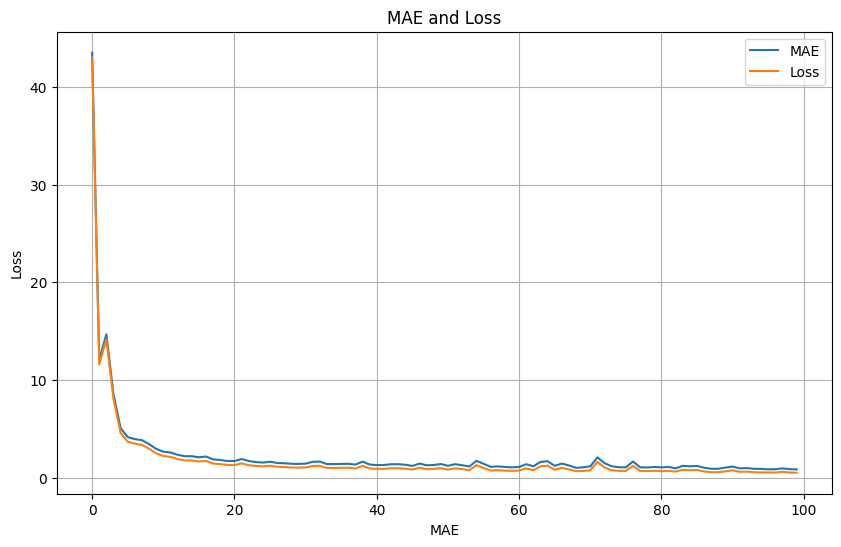

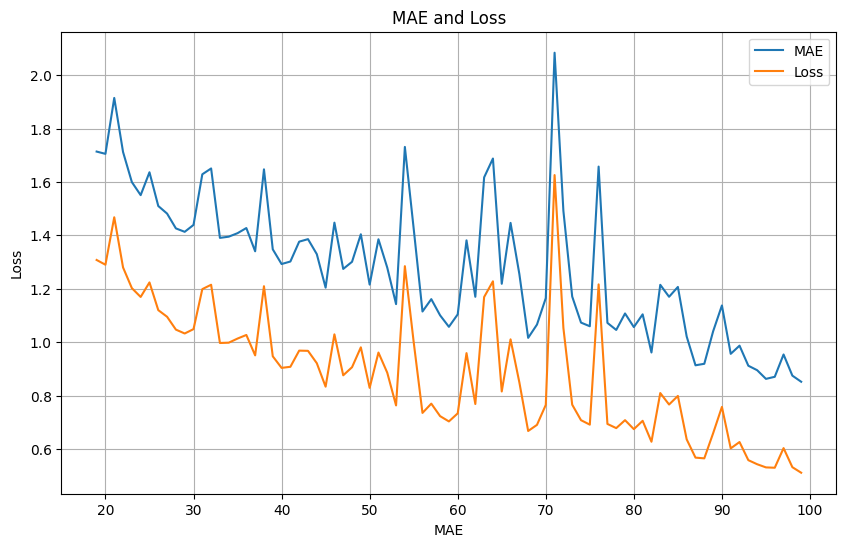

In [104]:
# Get mae and loss from history log
mae=history.history['mae']
loss=history.history['loss']

# Get number of epochs
epochs=range(len(loss))

# Plot mae and loss
plot_series(
    x=epochs,
    y=(mae, loss),
    title='MAE and Loss',
    xlabel='MAE',
    ylabel='Loss',
    legend=['MAE', 'Loss']
    )

# Only plot the last 80% of the epochs
zoom_split = int(epochs[-1] * 0.2)
epochs_zoom = epochs[zoom_split:]
mae_zoom = mae[zoom_split:]
loss_zoom = loss[zoom_split:]

# Plot zoomed mae and loss
plot_series(
    x=epochs_zoom,
    y=(mae_zoom, loss_zoom),
    title='MAE and Loss',
    xlabel='MAE',
    ylabel='Loss',
    legend=['MAE', 'Loss']
    )

# Model Prediction

In [105]:
def model_forecast(model, series, window_size, batch_size):
  """
  Forecasts the time series using the model

  Args:
    model - the model to use for forecasting
    series (array of int) - the time series
    window_size (int) - the window size

  Returns:
    forecast - the forecasted values
  """

  # Create a dataset from the series
  dataset = tf.data.Dataset.from_tensor_slices(series)

  # Window the dataset
  dataset = dataset.window(window_size, shift=1, drop_remainder=True)

  # Flatten the dataset
  dataset = dataset.flat_map(lambda window: window.batch(window_size))

  # Batch the dataset
  dataset = dataset.batch(32).prefetch(1)

  # Forecast the values
  forecast = model.predict(dataset)

  return forecast

1/1 [==============================] - 0s 56ms/step


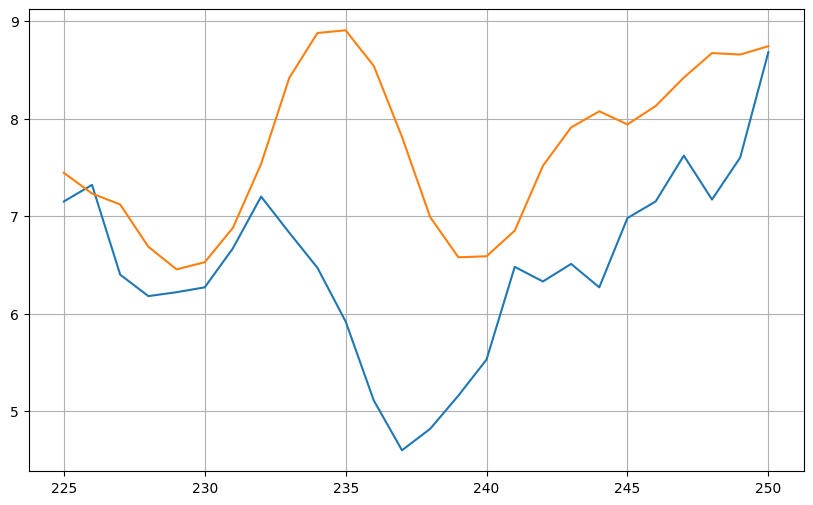

In [111]:
# Reduce the original series
forecast_series = series[split_time-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

In [107]:
# Compute the MAE
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

1.193218
